Copied from here:
https://github.com/gisbi-kim/symforce-tutorials/blob/main/pgo/1_pgo3d_toy/pose_graph_opt_3d_toy.ipynb


In [104]:
import os 
import copy 
import numpy as np
from numpy.linalg import inv
np.set_printoptions(suppress=True, precision=3)

from scipy.spatial.transform import Rotation as R

import symforce 
symforce.set_log_level("ERROR")
print(f"symforce uses {symforce.get_symbolic_api()} as backend")
from symforce.notebook_util import display
import symforce.symbolic as sf
from symforce.opt.factor import Factor
from symforce.opt.optimizer import Optimizer
from symforce.values import Values
from symforce import typing as sfT

%matplotlib inline
import matplotlib.pyplot as plt

# GTSAM requires pip3 install matplotlib==3.2.2
import gtsam
from gtsam.utils import plot
import json

from posefinder import VisualOdometry
import cv2
from tqdm import tqdm

symforce uses symengine as backend


In [105]:
# Load images for VO
path = "./CUSTOM_sequence/images/"

images = []
print("Loading images")
for fname in tqdm(os.listdir(path)):
        images.append((cv2.imread(os.path.join(path, fname), 0), fname))

# Sort images and remove names after sorting
images = sorted(images, key = lambda x: x[1])
images = list(map(lambda x: x[0], images))

Loading images


100%|██████████| 321/321 [00:03<00:00, 81.08it/s]


In [106]:
## Load poses

# initial pose (move by 0.1 to avoid singularities)
pose_start = np.eye(4)
pose_start[0,3] = 0.1 

curr_pose = pose_start
poses_gt = [curr_pose] # poses to be appended to this list 

# load poses
poses = None
with open('poses.json', 'r') as f:
    poses = json.load(f)["poses"]

# convert to python arrays
poses = list(map(lambda x: np.asarray(x), poses))
odoms_gt = []

for ii in range(len(poses) - 1):
    moved_pose, odom = poses[ii], poses[ii] @ inv(curr_pose)
    poses_gt.append(moved_pose)
    odoms_gt.append(odom)
    
    curr_pose = moved_pose

# generate loop factor (between the start and the end poses)
vo = VisualOdometry()

loops_gt = [] 
loops_indexes = [(250, 2), (248,15), (248,14)] # we know that there is a loop between these images

for loops_index_pair in loops_indexes:
    idx_from = loops_index_pair[0] # index of current pose
    idx_to = loops_index_pair[1] # index of matching pose

    ## calculate the delta between these two images using VO 
    loop_gt = vo.pose_from_images(images[idx_to], images[idx_from])
    loops_gt.append(loop_gt) 

print(loops_gt)

Camera Matrix: [[758.441   0.    604.736]
 [  0.    759.199 512.264]
 [  0.      0.      1.   ]]
Distortion Coefficients: [[-0.378]
 [ 0.511]
 [ 0.001]
 [ 0.002]
 [-0.907]]
[array([[ 0.97 ,  0.037, -0.238,  0.964],
       [-0.031,  0.999,  0.028, -0.08 ],
       [ 0.239, -0.02 ,  0.971,  0.254],
       [ 0.   ,  0.   ,  0.   ,  1.   ]]), array([[ 0.994,  0.023, -0.111, -0.259],
       [-0.022,  1.   ,  0.005, -0.044],
       [ 0.111, -0.003,  0.994,  0.965],
       [ 0.   ,  0.   ,  0.   ,  1.   ]]), array([[ 0.931,  0.101, -0.352,  0.706],
       [-0.067,  0.992,  0.107, -0.401],
       [ 0.36 , -0.076,  0.93 ,  0.584],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])]


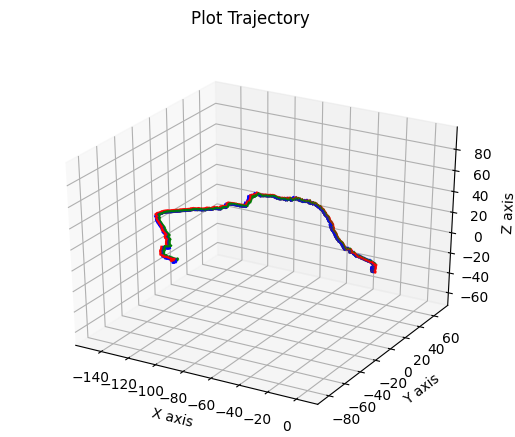

In [107]:
### draw the gt poses 
result = gtsam.Values()
for ii, pose_gt in enumerate(poses_gt):
    SE3 = np.eye(4)
    SE3[:3, :3] = pose_gt[:3, :3]
    SE3[:3, -1] = pose_gt[:3, -1]
    result.insert(ii, gtsam.Pose3(SE3))

# Plot GT trajectory
fig_idx = 1
plot.plot_trajectory(fig_idx, result, scale=1.5)
plot.set_axes_equal(True)
plt.show()

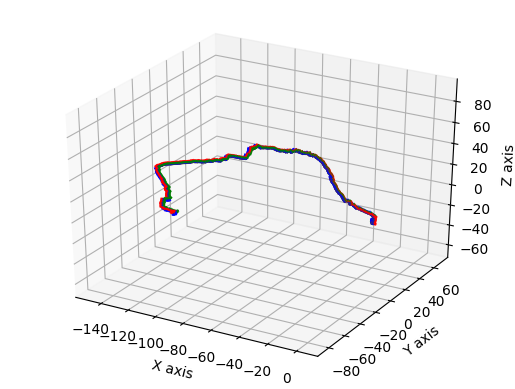

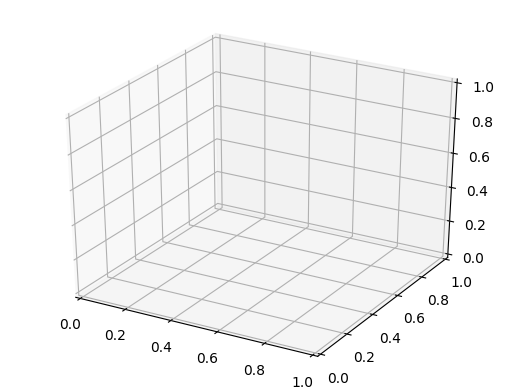

In [108]:
### Check that our poses from odometry are the same
result = gtsam.Values()
curr_pose = np.eye(4)
for ii, odom_gt in enumerate(odoms_gt):
    curr_pose = odom_gt @ curr_pose
    result.insert(ii, gtsam.Pose3(curr_pose))

# Plot GT trajectory
fig_idx = 2
plot.plot_incremental_trajectory(2, result, scale=1.5, time_interval=0.1)
plot.set_axes_equal(True)
plt.show()

In [109]:
# error models (cost functions)
eps = 0.000001

# Error between currently optimized poses and our odometry-derived translation delta between poses
def odometry_residual(
        pose_prev: sf.Pose3, 
        pose_next: sf.Pose3, 
        movement : sf.Pose3
    ) -> sf.V6:
    
    # The original reference of the below lines 
    #  - see https://github.com/symforce-org/symforce/blob/main/symforce/examples/robot_3d_localization/robot_3d_localization.py#L63

    movement_predicted = pose_prev.inverse() * pose_next
    tangent_error = movement_predicted.local_coordinates(movement, epsilon=eps)
    return tangent_error

# Error between poses except the poses are coming from loop detection
def loop_residual(
        pose_prev: sf.Pose3, 
        pose_next: sf.Pose3, 
        movement : sf.Pose3
    ) -> sf.V6:

    movement_predicted = pose_prev.inverse() * pose_next
    tangent_error = movement_predicted.local_coordinates(movement, epsilon=eps)
    return tangent_error

In [115]:
## Convert our 4x4 numpy matrices to SF SE(3) representation
def np2sf_batch(mats_np):

    def SE3_np2sf(mat: np.ndarray):
        mat_sf = sf.Pose3.identity()
        mat_sf.t = sf.V3(mat[:3, -1])
        mat_sf.R = sf.Rot3.from_rotation_matrix(mat[:3, :3], epsilon=sf.numeric_epsilon)
        return mat_sf

    mats_sf = []
    for mat in mats_np:
        mats_sf.append(SE3_np2sf(mat))    
        
    return mats_sf

# Create arrays of sf.SE3 poses from np 4x4 mats 
poses_prior = np2sf_batch(poses_gt)
odoms_obs   = np2sf_batch(odoms_gt)
loops_obs   = np2sf_batch(loops_gt)

## initial values (note that using identity cannot converges, thus perturb the prior value and use it.)
initial_poses = []
for ii, pose_prior in enumerate(poses_prior):
    initial_poses.append(pose_prior)

# wtf is this?
initial_values = Values(
    poses=initial_poses,
    odoms=odoms_obs,
    loops=loops_obs
)

print(loops_obs)

[<Pose3 R=<Rot3 <Q xyzw=[-0.0119623285570672, -0.120309304982514, -0.0169404717042592, 0.992519820582216]>>, t=(0.963933347542881, -0.0796887770999165, 0.253933863561828)>, <Pose3 R=<Rot3 <Q xyzw=[-0.00205679242056929, -0.05544453902038, -0.0113622677467652, 0.998394997768622]>>, t=(-0.258862913158661, -0.0439617550281904, 0.96491319401749)>, <Pose3 R=<Rot3 <Q xyzw=[-0.0467420825970609, -0.181221277543732, -0.0426065899788658, 0.981406493136397]>>, t=(0.705930509688906, -0.400671729748181, 0.584058447267219)>]


In [116]:
use_factors = {
    'odometry': True,
    'loop': True, # test True or False
}

factors = []
num_poses = len(poses)

# 1. Odometry factors
if use_factors['odometry']:        
    for i in range(num_poses-1):        
        factors.append(Factor(
            residual=odometry_residual,
            keys=[f"poses[{i}]", f"poses[{i+1}]", f"odoms[{i}]"],
        ))

# 2. Loop factors
if use_factors['loop']:
    for ii, loops_index_pair in enumerate(loops_indexes):    
        idx_from = loops_index_pair[0]
        idx_to = loops_index_pair[1]
        factors.append(Factor(
            residual=loop_residual,
            keys=[f"poses[{idx_from}]", f"poses[{idx_to}]", f"loops[{ii}]"],
        ))

## do opt 
optimizer = Optimizer(
    factors=factors,
    optimized_keys=[f"poses[{i}]" for i in range(num_poses)],
    debug_stats=True,
    params=Optimizer.Params(verbose=True, initial_lambda=1e4, lambda_down_factor=1 / 2.0)
)

# result vis 
result = optimizer.optimize(initial_values)
poses_opt = result.optimized_values['poses']

print(vars(result).keys())

dict_keys(['initial_values', 'optimized_values', '_stats'])


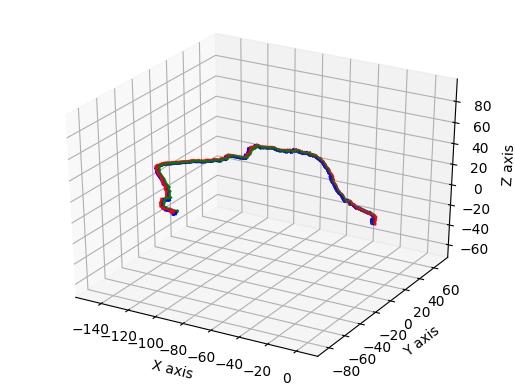

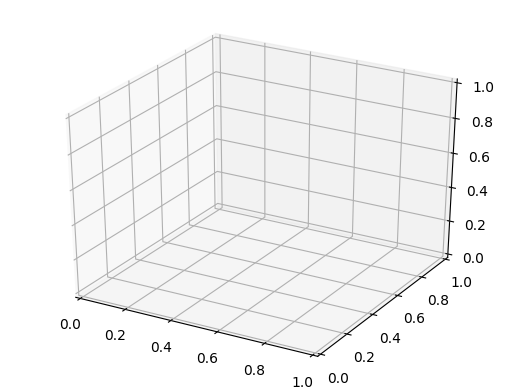

In [117]:
### draw the result 

# gather data 
result = gtsam.Values()
for ii, pose_opt in enumerate(poses_opt):
    pose7 = pose_opt.data
    t = np.array(pose7[4:])
    q = np.array(pose7[:4])
    SE3 = np.eye(4)
    SE3[:3, :3] = R.from_quat(q).as_matrix()
    SE3[:3, -1] = t
    result.insert(ii, gtsam.Pose3(SE3))

# draw
# plot.plot_incremental_trajectory(3, result, scale=2.9)
plot.plot_incremental_trajectory(3, result, scale=1.5, time_interval=0.1)
plot.set_axes_equal(2)
plt.show()